In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import random

from obspy import read

In [44]:
signal_samples = 301
station_count = 56
time_arr = np.linspace(0.0, 30.0, signal_samples)
time_arr.shape

(301,)

In [3]:
# plot wave normal
def plot_wave_processed(data):
    fig = plt.figure(figsize=(15, 4))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, len(data))]
    i = 0
    for s in data:
        ax.plot(time_arr, s, color=colors[i])
        i+=1
    ax.tick_params(axis='both', labelsize=15)
    ax.tick_params(axis='both', labelsize=15)
    plt.ylabel('HHZ Velocity', fontsize=20)
    plt.xlabel('Timestep', fontsize=20);
    plt.grid()
    plt.show()
    del fig
    del ax

In [4]:
# READING NORMAL BEHAVIOUR
pkl_file = open('../datasets/normal/waveforms/100hz/normal_seismic_100hz.pkl', 'rb')
normal_data = pickle.load(pkl_file)
pkl_file.close()
(len(normal_data), len(normal_data[0]), len(normal_data[0][0]))

(2904, 56, 301)

In [5]:
# READING activbe BEHAVIOUR
pkl_file = open('../datasets/active/waveforms/100hz/normal_seismic_100hz.pkl', 'rb')
earthquakes_data = pickle.load(pkl_file)
pkl_file.close()
(len(earthquakes_data), len(earthquakes_data[0]), len(earthquakes_data[0][0]))

(2872, 56, 301)

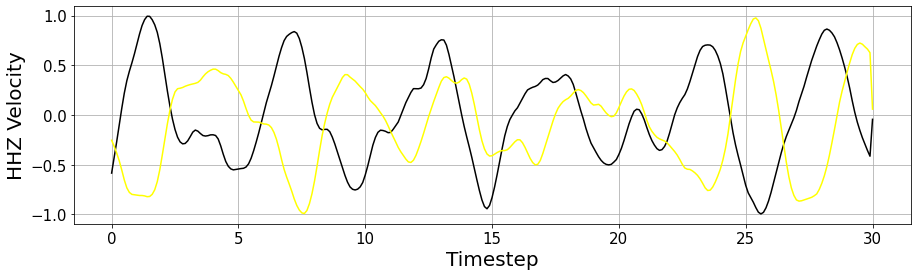

In [177]:
plot_wave_processed([earthquakes_data[0][0], normal_data[0][0]])

In [66]:
#def filter_data(data):
#    # check for possible nans and incomplete station data
#    
#    for i in range(0, len(data)):
#        stations = data[i]
#        if len(stations) != station_count:
#            
#        for d in range(0, data[i]):
#            print()

def check_nans_incomplete_stations(data):
    
    # check for possible nans and incomplete station data
    nan_arr = []
    not_58_stations = []
    not_61_samples = []

    for i in range(0, len(data)):
        
        try:
            # stations != 58 per event
            if len(data[i]) != station_count:
                not_58_stations.append(i)
                
            for j in range(0, station_count):
                
                try:
                    if len(data[i][j]) != signal_samples:
                        not_61_samples.append(i)
                # a station has nan value(s)
                    
                    is_nan_event = np.isnan(np.sum(data[i][j]))
                    if is_nan_event:
                        nan_arr.append(i)
                    
                except:
                    print(len(data[i]))
                    not_61_samples.append(i)
                
        except:
            print(len(data[i]))
            not_58_stations.append(i)
            
        
                
    return nan_arr, not_58_stations, not_61_samples

# verify that we only have one shape for stations and samples
def verify_unique_shapes(data):
    stations_shape = [station_count]
    samples_shape = [signal_samples]
    
    for i in data:
        station_shape = len(i)
    
        if station_shape not in stations_shape:
            stations_shape.append(station_shape)
            
        for j in i:
            sample_shape = len(j)
            if sample_shape not in samples_shape:
                samples_shape.append(sample_shape)
    
    return stations_shape, samples_shape

In [73]:
def remove_incomplete(data, processed):
    nan_arr_e, not_58_stations_e, not_61_samples_e = check_nans_incomplete_stations(data)
    print(len(nan_arr_e), len(not_58_stations_e), len(not_61_samples_e))
    remove_indices = [y for x in [nan_arr_e, not_58_stations_e] for y in x]
    remove_indices = [y for x in [remove_indices, not_61_samples_e] for y in x]
    remove_indices = set(remove_indices)
    remove_indices = list(remove_indices)
    processed = [i for j, i in enumerate(processed) if j not in remove_indices]
    return processed

In [76]:
#earthquakes_data_processed = earthquakes_data
#normal_data_processed = normal_data
earthquakes_data_processed = remove_incomplete(earthquakes_data, earthquakes_data_processed)
normal_data_processed = remove_incomplete(normal_data, normal_data_processed)
#filter_data(earthquakes_data)

0 0 153
0 0 162


In [77]:
len(earthquakes_data_processed)

2415

In [78]:
nan_arr_e, not_58_stations_e, not_61_samples_e = check_nans_incomplete_stations(earthquakes_data_processed)

In [79]:
len(nan_arr_e), len(not_58_stations_e), len(not_61_samples_e)

(0, 0, 0)

In [80]:
verify_unique_shapes(earthquakes_data_processed)
#for event in earthquakes_data_processed:
#    if event.shape != (station_count, signal_samples):
#        print(event.shape)

([56], [301])

In [81]:
(len(earthquakes_data_processed), len(earthquakes_data_processed[0]), len(earthquakes_data_processed[0][0]))

(2415, 56, 301)

In [82]:
# same length as normal
same = min(len(earthquakes_data_processed), len(normal_data_processed))
earthquakes_data_processed = earthquakes_data_processed[0:same]
normal_data_processed = normal_data_processed[0:same]
same

2415

In [83]:
# turns data to lstm input for training
def to_lstm_input(read_file, label):
    lstm_event_arr = []
    for i, r in enumerate(read_file):
        arr = read_file[i]
        arr_t = np.transpose(arr)
        try:
            arr_t = arr_t.reshape(signal_samples, station_count)
        except:
            continue
        lstm_event_arr.append({label: arr_t})
    lstm_event_arr = np.array(lstm_event_arr)
    return lstm_event_arr

In [85]:
earthquakes_data_processed = np.array(earthquakes_data_processed)
normal_data_processed = np.array(normal_data_processed)

In [87]:
earthquakes_data_processed.shape

(2415, 56, 301)

In [88]:
# earthquakes == 1
lstm_input_earthquakes = to_lstm_input(earthquakes_data_processed, '1')

In [89]:
# normal == 0
lstm_input_normal = to_lstm_input(normal_data_processed,'0')

In [90]:
lstm_input_earthquakes.shape, lstm_input_normal.shape

((2415,), (2415,))

In [155]:
# shuffle the data set, while maintaining order

def shuffle(test_list1, test_list2):
    c1 = 0
    c2 = 0
    out = []
    n = len(test_list1) + len(test_list2)
    for i in range(n):
        diff = 10 * (c1 - c2)/n
        ledge = max(min(0.5 + diff, 1), 0)
        if random.random() > ledge and c1 < len(test_list1):
            out.append(test_list1[c1])
            c1+=1
        elif c2 < len(test_list2):
            out.append(test_list2[c2])
            c2+=1
    print(c1/c2)
    out = np.concatenate((out, test_list1[c1:]))
    out = np.concatenate((out, test_list2[c2:]))
    return np.array(out)
        
lstm_input = shuffle(lstm_input_earthquakes, lstm_input_normal)

#lstm_input = np.concatenate((lstm_input_earthquakes, lstm_input_normal))
#np.random.shuffle(lstm_input)

In [156]:
#lstm_input = np.concatenate((ls1, ls2))
lstm_input.shape

(4830,)

In [157]:
train_ratio = 0.7
valid_ratio = 0.1
def regular_split():
    #(70 training - 20 validation - 10 test split)
    full_n = len(lstm_input)
    train_n = round(full_n*train_ratio)
    valid_n = train_n + round(full_n*valid_ratio)
    
    training_set = lstm_input[:train_n]
    validation_set = lstm_input[train_n:valid_n]
    test_set = lstm_input[valid_n:]
    return training_set, validation_set, test_set
def k_fold(k):
    training_set = []
    validation_set = []
    test_set = []
    splits = np.array_split(lstm_input, k)
    for split in splits:
        full_n = len(split)
        train_n = round(full_n*train_ratio)
        valid_n = train_n + round(full_n*valid_ratio)
        training_set.append(split[:train_n])
        validation_set.append(split[train_n:valid_n])
        test_set.append(split[valid_n:])
    return np.array(training_set).flatten(), np.array(validation_set).flatten(), np.array(test_set).flatten()
    
training_set, validation_set, test_set = k_fold(5)
#training_set, validation_set, test_set = regular_split()
len(training_set), len(validation_set), len(test_set)

(3380, 485, 965)

In [158]:
x_train = []
y_train = []
for i, r in enumerate(training_set):
    arr = training_set[i]
    key = list(training_set[i].keys())[0]
    if key == '1':
        y_train.append(1)
    else:
        y_train.append(0)
    
    x_train.append(arr[key])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [159]:
x_train.shape, y_train.shape

((3380, 301, 56), (3380,))

In [160]:
#os.chdir('../100HZ')
os.getcwd()

'C:\\Programming\\Earthquake\\models'

In [161]:
pickle.dump(x_train, open("../datasets/100hz/x_train.pkl", "wb"))
pickle.dump(y_train, open("../datasets/100hz/y_train.pkl", "wb"))

In [162]:
len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0]), len(np.where(y_train == 0)[0]) / len(y_train), len(np.where(y_train == 1)[0]) / len(y_train)

(1678, 1702, 0.49644970414201184, 0.5035502958579882)

In [163]:
x_validation = []
y_validation = []
for i, r in enumerate(validation_set):
    arr = validation_set[i]
    key = list(validation_set[i].keys())[0]
    if key == '1':
        y_validation.append(1)
    else:
        y_validation.append(0)
    
    x_validation.append(arr[key])
    
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)

In [164]:
x_validation.shape, y_validation.shape

((485, 301, 56), (485,))

In [165]:
len(np.where(y_validation == 0)[0]), len(np.where(y_validation == 1)[0]), len(np.where(y_validation == 0)[0]) / len(y_validation), len(np.where(y_validation == 1)[0]) / len(y_validation)


(243, 242, 0.5010309278350515, 0.49896907216494846)

In [166]:
pickle.dump(x_validation, open("../datasets/100hz/x_validation.pkl", "wb"))
pickle.dump(y_validation, open("../datasets/100hz/y_validation.pkl", "wb"))

In [167]:
x_test = []
y_test = []
for i, r in enumerate(test_set):
    arr = test_set[i]
    key = list(test_set[i].keys())[0]
    if key == '1':
        y_test.append(1)
    else:
        y_test.append(0)
    
    x_test.append(arr[key])
    
x_test = np.array(x_test)
y_test = np.array(y_test)

In [168]:
x_test.shape, y_test.shape

((965, 301, 56), (965,))

In [169]:
len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0]), len(np.where(y_test == 0)[0]) / len(y_test) , len(np.where(y_test == 1)[0]) / len(y_test)

(494, 471, 0.5119170984455959, 0.48808290155440415)

In [170]:
pickle.dump(x_test, open("../datasets/100hz/x_test.pkl", "wb"))
pickle.dump(y_test, open("../datasets/100hz/y_test.pkl", "wb"))

([], [])

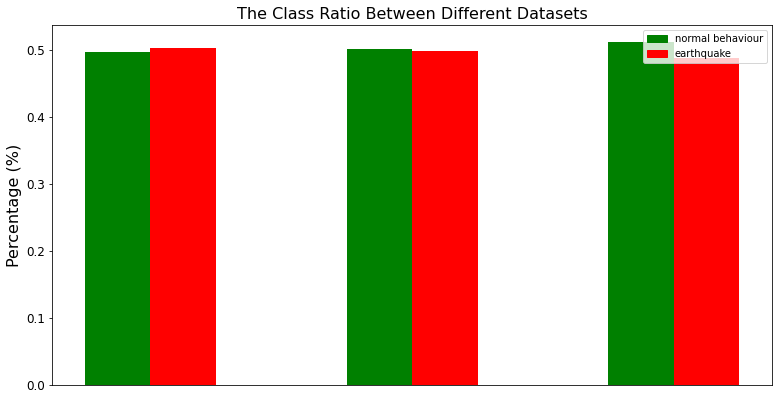

In [171]:
data = [[len(np.where(y_train == 0)[0]) / len(y_train),
        len(np.where(y_validation == 0)[0]) / len(y_validation),
        len(np.where(y_test == 0)[0]) / len(y_test)],
        
       [len(np.where(y_train == 1)[0]) / len(y_train),
        len(np.where(y_validation == 1)[0]) / len(y_validation),
        len(np.where(y_test == 1)[0]) / len(y_test)]]

X = np.arange(3)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
colors = {'normal behaviour':'green', 'earthquake':'red'}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.title("The Class Ratio Between Different Datasets", fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks([])

In [746]:
#x_train = pickle.load(open("../datasets/5hz/x_train.pkl", "rb"))
#y_train = pickle.load(open("../datasets/5hz/y_train.pkl", "rb"))
#
#x_validation = pickle.load(open("../datasets/5hz/x_validation.pkl", "rb"))
#y_validation = pickle.load(open("../datasets/5hz/y_validation.pkl", "rb"))
#
#x_test = pickle.load(open("../datasets/5hz/x_test.pkl", "rb"))
#y_test = pickle.load(open("../datasets/5hz/y_test.pkl", "rb"))

In [747]:
#x_train.shape, y_train.shape

In [748]:
#x_validation.shape, y_validation.shape

In [749]:
#x_test.shape, y_test.shape

In [750]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_train)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [751]:
#verify_unique_shapes_preprocessed(x_train)

In [752]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_validation)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [753]:
#verify_unique_shapes_preprocessed(x_validation)

In [754]:
#nan_arr_n, not_58_stations_n, not_61_samples_n = check_nans_incomplete_stations_preprocessed(x_test)
#len(nan_arr_n), len(not_58_stations_n), len(not_61_samples_n)

In [755]:
#verify_unique_shapes_preprocessed(x_test)

In [756]:
#os.getcwd()

In [757]:
#os.chdir('../../../../../')

In [758]:
#os.chdir('Volumes/My Passport')

In [759]:
#e = pickle.load(open("normal_seismic_50hz.pkl", "rb"))

In [760]:
#e.shape

In [761]:
#en = e[:1000]

In [762]:
#en.shape

In [763]:
#pickle.dump(en, open("n_normal_sesimic_50hz.pkl", "wb"))